In [1]:
import networkx as nx
import community as community_louvain
import numpy as np
import locale
import time

### Création du graphe à partir du fichier `edgelist`

In [2]:
G = nx.read_edgelist("youtube.graph.edgelist", nodetype=int)

In [3]:
N = G.number_of_nodes()
m = G.number_of_edges()
nb_composantes = nx.number_connected_components(G)

In [4]:
print(f"nombre de nœuds : {N}")
print(f"nombre d’arêtes : {m}")
print(f"nombre de composantes connexes : {nb_composantes}")
print(f"voisins du nœud 1 : {list(G.neighbors(11))}")

nombre de nœuds : 22754
nombre d’arêtes : 65601
nombre de composantes connexes : 1
voisins du nœud 1 : [165, 349, 718, 727, 743, 905, 908, 1042, 1073, 1119, 3491, 3493, 3511, 3517, 3518, 3519, 3533, 3535, 3540, 3542, 3546, 3548, 3558, 3559, 3562, 5109, 13568, 655575, 663545, 665658, 665659, 1085697]


### Budget idéal et couverture idéale

In [5]:
def ideal_budget_and_coverage(N, C_0=200):
    return C_0*N, 1

In [6]:
C_0 = 200
ideal_budget, ideal_coverage = ideal_budget_and_coverage(N, C_0)
print(f"budget idéal = {ideal_budget:,.2f} CAD et couverture idéale = {ideal_coverage:.0%}")

budget idéal = 4,550,800.00 CAD et couverture idéale = 100%


### Détection des communautés à l’aide de l’algorithme de Louvain.

In [7]:
def get_communities(G, algo="louvain"):
    communities = {}
    if algo=="louvain":
        partition = community_louvain.best_partition(G)
        for node, comm in partition.items():
            communities.setdefault(comm, []).append(node)
    else:
        lpa_communities = nx.algorithms.community.label_propagation_communities(G)
        lpa_result = [list(c) for c in lpa_communities]
        for i, comm in enumerate(lpa_communities):
            communities[i] = list(comm)   
    return communities

In [8]:
communities_lpa = get_communities(G, algo="lpa")
print("nombre total de communautés détectées :", len(communities_lpa))

nombre total de communautés détectées : 1319


In [9]:
communities_louvain = get_communities(G, algo="louvain")
print("nombre total de communautés détectées :", len(communities_louvain))

nombre total de communautés détectées : 41


### Détermination d’un·e influenceur·euse par communauté, choisi·e selon la centralité de proximité

In [10]:
def get_community_and_profiles(G, communities, influence="closeness"):
    com_and_profiles = {}
    for comm_id, nodes in communities.items():
        community = G.subgraph(nodes)
        if influence=="closeness":
            closeness = nx.closeness_centrality(community)
            influencer = max(closeness, key=closeness.get)
        elif influence=="degree":
            degree = nx.degree_centrality(community)
            influencer = max(degree, key=degree.get)
        elif influence=="betweenness":
            betweenness = nx.betweenness_centrality(community)
            influencer = max(betweenness, key=betweenness.get)
        else:
            influencer = np.random.choice(list(nodes))
        profile = {"community":community, "influencer": influencer}
        com_and_profiles[comm_id]=profile
    return com_and_profiles 

In [11]:
com_and_profiles_louvain = get_community_and_profiles(G, communities_louvain, influence="closeness")

In [12]:
com_and_profiles_lpa = get_community_and_profiles(G, communities_lpa, influence="random")

###  Simulation du budget et de la couverture obtenue par propagation de l’influence

In [ ]:
def get_budget_coverage_per_community(com_and_profile, N, eta = 2, C_1=20, C_2=1000):
    community = com_and_profile['community']
    influencer = com_and_profile['influencer']
    counter = 1
    temps_propagation = 0
    for node in community.nodes():
        if node != influencer:
            prob = np.random.uniform(0.8, 1)
            choice = np.random.choice([0, 1], p=[1-prob, prob])
            if choice == 1:
                try:
                    distance = nx.shortest_path_length(community, source=influencer, target=node)
                    counter +=1
                    temps_propagation += distance
                except Exception as e:
                    continue
                
    budget = C_2 + (counter-1)*C_1
    temps_propagation *= eta
    
    coverage = counter/N
    return budget, coverage, temps_propagation

In [14]:
def get_budget_and_coverage(com_and_profiles, N,eta=2, C_1=20, C_2=1000):
    total_budget, total_coverage, total_temps_propagation = 0, 0, 0
    for comm_id in com_and_profiles:
        com_and_profile = com_and_profiles[comm_id]
        budget, coverage, temps_propagation = get_budget_coverage_per_community(com_and_profile, N, eta, C_1, C_2)
        total_budget +=budget
        total_coverage +=coverage
        total_temps_propagation +=temps_propagation
    return total_budget, total_coverage, total_temps_propagation

In [15]:
eta, C_1, C_2 =2, 20, 1000

In [16]:
sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles_louvain, eta, C_1, C_2)
print(f"budget simulé = {sim_budget:,.2f} CAD, couverture simulée = {sim_coverage:.0%} et temps de propagation = {sim_temps_propagation:,.2f} sec ")

budget simulé = 20,477,000.00 CAD, couverture simulée = 1023850% et temps de propagation = 930,000.00 sec 


In [17]:
sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(com_and_profiles_lpa, eta, C_1, C_2)
print(f"budget simulé = {sim_budget:,.2f} CAD, couverture simulée = {sim_coverage:.0%} et temps de propagation = {sim_temps_propagation:,.2f} sec ")

budget simulé = 20,610,000.00 CAD, couverture simulée = 1030500% et temps de propagation = 1,375,760.00 sec 


### Comparez les différents résultats obtenus

Comparez les différents résultats obtenus selon la méthode de détection des communautés et l’approche de détermination des nœuds influenceurs, 
      en termes de budget simulé, de couverture simulée, de temps total de propagation et de temps d’exécution. Proposez des visualisations pertinentes afin de faciliter la comparaison des résultats, notamment en termes de couverture perdue et de montant d’argent épargné par approche.

In [18]:
scenarios = []
scenarios.extend([
    ('Louvain', 'closeness', 'LC'), # Louvain / Centralité de Proximité
        ('Louvain', 'random', 'LR'),
        ('Louvain', 'degree', 'LD'), # Louvain / Centralité de Degré
        ('Louvain', 'betweenness', 'LB'), # Louvain / Centralité d'Intermédiarité
])

scenarios.extend([
    ('LPA', 'closeness', 'AC'), # LPA / Centralité de Proximité
        ('LPA', 'random', 'AR'),
        ('LPA', 'degree', 'AD'), # LPA / Centralité de Degré
        ('LPA', 'betweenness', 'AB'), # LPA / Centralité d'Intermédiarité
])

results = []
ideal_budget, ideal_coverage = ideal_budget_and_coverage(N, C_0)
comm_data = {}

for algo,influence, label in scenarios:
    print(f"--- Exécution: {label} ({algo} + {influence}) ---")

    if algo not in comm_data:
        start_comm = time.time()
        try:
            communities = get_communities(G, algo=algo.lower())
            end_comm = time.time()
            time_comm = end_comm - start_comm
            
            # Stocker les résultats de la détection et le temps
            comm_data[algo] = {
                'communities': communities, 
                'time_comm': time_comm
            }
        except ValueError as e:
            print(f"Skipping {algo} due to error: {e}")
            continue
    else:
        # Récupération du cache
        communities = comm_data[algo]['communities']
        time_comm = comm_data[algo]['time_comm']

# --- 2. Sélection de l'Influenceur (Dépend de la métrique) et Mesure du Temps ---
    start_profile = time.time()
    # ATTENTION: Il faut recalculer les profils DANS la boucle car l'influence change
    com_and_profiles = get_community_and_profiles(G, communities, influence=influence.lower())
    end_profile = time.time()
    time_profile = end_profile - start_profile


    # --- 3. Simulation et Mesure du Temps ---
    start_sim = time.time()
    # La fonction get_budget_and_coverage doit prendre N, C_1, C_2, eta comme arguments.
    # J'ai ajouté N ci-dessous en me basant sur le contexte implicite.
    sim_budget, sim_coverage, sim_temps_propagation = get_budget_and_coverage(
        com_and_profiles, N,    eta, C_1, C_2 
    ) 
    end_sim = time.time()
    time_sim = end_sim - start_sim
    total_time = time_comm + time_profile + time_sim

    # --- 4. Calcul des Métriques Dérivées et Enregistrement ---
    budget_saved = ideal_budget - sim_budget
    coverage_lost = ideal_coverage - sim_coverage

    results.append({
        'Scenario': label,
        'Method': f'{algo}/{influence}',
        'Algo': algo,
        'Influence_Metric': influence,
        'Sim_Budget': sim_budget,
        'Sim_Coverage': sim_coverage,
        'Sim_Propagation_Time': sim_temps_propagation,
        'Exec_Time_Comm_Detect': time_comm,
        'Exec_Time_Influencer': time_profile,
        'Exec_Time_Simulation': time_sim,
        'Total_Execution_Time': total_time,
        'Budget_Saved': budget_saved,
        'Lost_Coverage': coverage_lost
    })

--- Exécution: LC (Louvain + closeness) ---
--- Exécution: LR (Louvain + random) ---
--- Exécution: LD (Louvain + degree) ---
--- Exécution: LB (Louvain + betweenness) ---
--- Exécution: AC (LPA + closeness) ---
--- Exécution: AR (LPA + random) ---
--- Exécution: AD (LPA + degree) ---
--- Exécution: AB (LPA + betweenness) ---


In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd



--- Tableau de Comparaison des Résultats (CAD) ---
| Scenario   | Method              |   Sim_Budget |   Sim_Coverage |   Sim_Propagation_Time |   Exec_Time_Comm_Detect |   Exec_Time_Influencer |   Exec_Time_Simulation |   Total_Execution_Time |   Budget_Saved |   Lost_Coverage |
|:-----------|:--------------------|-------------:|---------------:|-----------------------:|------------------------:|-----------------------:|-----------------------:|-----------------------:|---------------:|----------------:|
| LC         | Louvain/closeness   |       441860 |          0.898 |                  92558 |                    2.52 |                  99.47 |                   2.98 |                 104.97 |        4108940 |         0.10227 |
| LR         | Louvain/random      |       443460 |          0.901 |                 153606 |                    2.52 |                   0.01 |                   1.05 |                   3.57 |        4107340 |         0.09875 |
| LD         | Louvain/degr

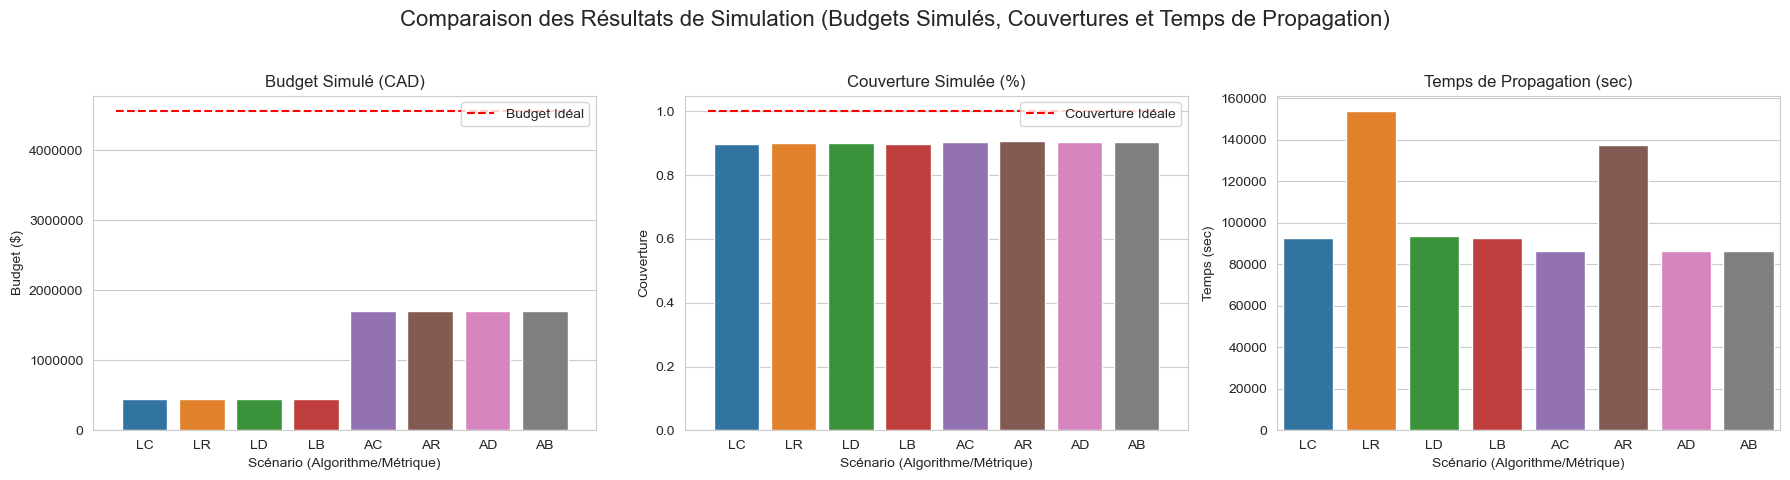

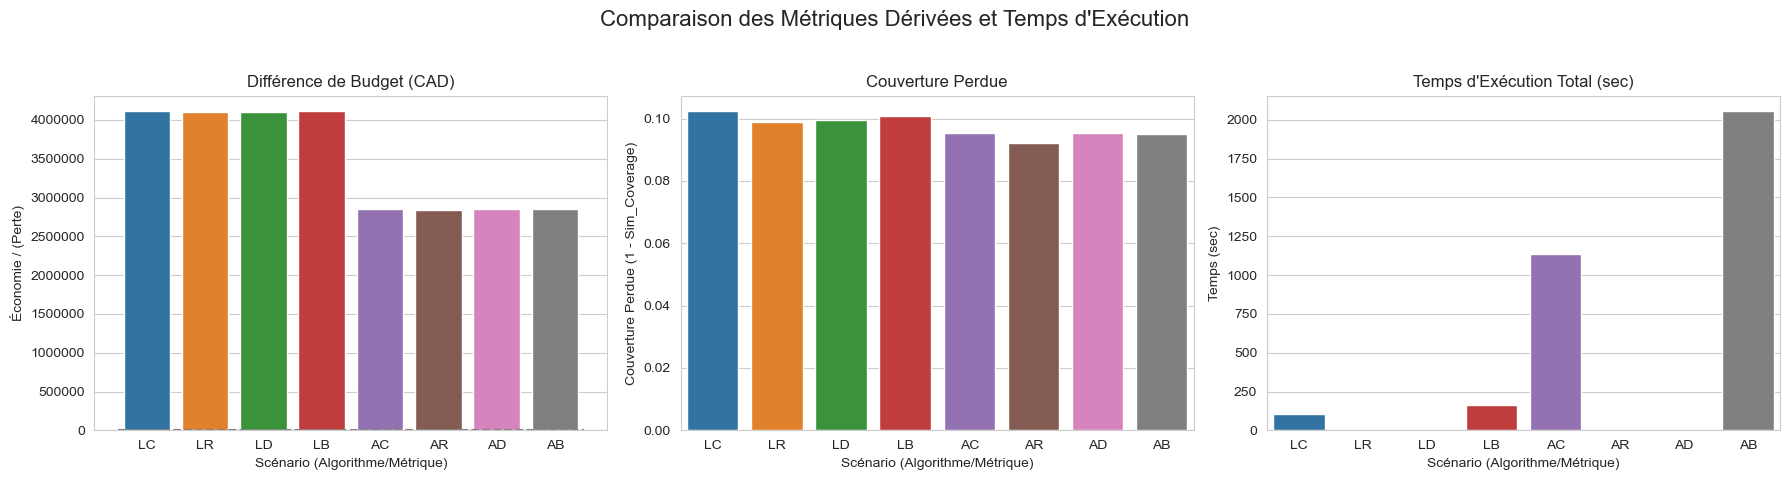

In [21]:
# Affichage des résultats

df_results = pd.DataFrame(results)

print("\n\n--- Tableau de Comparaison des Résultats (CAD) ---")
print(df_results[['Scenario', 'Method', 'Sim_Budget', 'Sim_Coverage', 'Sim_Propagation_Time',
              'Exec_Time_Comm_Detect', 'Exec_Time_Influencer', 'Exec_Time_Simulation',
              'Total_Execution_Time', 'Budget_Saved', 'Lost_Coverage']].to_markdown(
    index=False, 
    # Le formatage doit correspondre à l'ordre des colonnes :
    floatfmt=(
        None,      # Scenario (string)
        None,      # Method (string)
        ",.2f",    # Sim_Budget
        ".3f",     # Sim_Coverage (0.905 devient 0.905)
        ",.2f",    # Sim_Propagation_Time
        ".2f",     # Exec_Time_Comm_Detect
        ".2f",     # Exec_Time_Influencer
        ".2f",     # Exec_Time_Simulation <--- DOIT ÊTRE UN FORMAT DÉCIMAL (.2f)
        ".2f",     # Total_Execution_Time
        ",.2f",    # Budget_Saved
        ".5f"      # Lost_Coverage (0.104465 devient 0.10446)
    )
))

print(f"\nBudget Idéal (100% couverture): {ideal_budget:,.2f} CAD")

ideal_budget = ideal_budget
ideal_coverage = ideal_coverage

sns.set_style(style="whitegrid")

# ==============================================================================
# 1. Visualisation des Métriques Clés (Budget, Couverture, Temps Propagation)
# ==============================================================================

fig1, axes1 = plt.subplots(1, 3, figsize=(18, 5))
fig1.suptitle('Comparaison des Résultats de Simulation (Budgets Simulés, Couvertures et Temps de Propagation)', fontsize=16)

# --- Budget Simulé ---
# Utilisation de hue='Scenario' pour une couleur unique par barre
sns.barplot(x='Scenario', y='Sim_Budget', data=df_results, hue='Scenario', dodge=False, ax=axes1[0], legend=False)
axes1[0].set_title('Budget Simulé (CAD)')
axes1[0].set_ylabel('Budget ($)')
axes1[0].ticklabel_format(style='plain', axis='y')
axes1[0].hlines(ideal_budget, xmin=-0.5, xmax=len(df_results)-0.5, color='red', linestyle='--', label='Budget Idéal')
axes1[0].legend()

# --- Couverture Simulée ---
# Utilisation de hue='Scenario'
sns.barplot(x='Scenario', y='Sim_Coverage', data=df_results, hue='Scenario', dodge=False, ax=axes1[1], legend=False)
axes1[1].set_title('Couverture Simulée (%)')
axes1[1].set_ylabel('Couverture')
axes1[1].hlines(ideal_coverage, xmin=-0.5, xmax=len(df_results)-0.5, color='red', linestyle='--', label='Couverture Idéale')
axes1[1].legend()

# --- Temps de Propagation ---
# Utilisation de hue='Scenario'
sns.barplot(x='Scenario', y='Sim_Propagation_Time', data=df_results, hue='Scenario', dodge=False, ax=axes1[2], legend=False)
axes1[2].set_title('Temps de Propagation (sec)')
axes1[2].set_ylabel('Temps (sec)')
axes1[2].ticklabel_format(style='plain', axis='y')

for ax in axes1:
    ax.set_xlabel('Scénario (Algorithme/Métrique)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ==============================================================================
# 2. Visualisation des Métriques Dérivées et Temps d'Exécution
# ==============================================================================

fig2, axes2 = plt.subplots(1, 3, figsize=(18, 5))
fig2.suptitle('Comparaison des Métriques Dérivées et Temps d\'Exécution', fontsize=16)

# --- Budget Économisé/perdu selon les cas ---
# Utilisation de hue='Scenario'
sns.barplot(x='Scenario', y='Budget_Saved', data=df_results, hue='Scenario', dodge=False, ax=axes2[0], legend=False)
axes2[0].set_title('Différence de Budget (CAD)')
axes2[0].set_ylabel('Économie / (Perte)')
axes2[0].ticklabel_format(style='plain', axis='y')
axes2[0].hlines(0, xmin=-0.5, xmax=len(df_results)-0.5, color='grey', linestyle='--')

# --- Couverture Perdue ---
# Utilisation de hue='Scenario'
sns.barplot(x='Scenario', y='Lost_Coverage', data=df_results, hue='Scenario', dodge=False, ax=axes2[1], legend=False)
axes2[1].set_title('Couverture Perdue')
axes2[1].set_ylabel('Couverture Perdue (1 - Sim_Coverage)')

# --- Temps d'Exécution Total ---
# Utilisation de hue='Scenario'
sns.barplot(x='Scenario', y='Total_Execution_Time', data=df_results, hue='Scenario', dodge=False, ax=axes2[2], legend=False)
axes2[2].set_title('Temps d\'Exécution Total (sec)')
axes2[2].set_ylabel('Temps (sec)')

for ax in axes2:
    ax.set_xlabel('Scénario (Algorithme/Métrique)')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()